# RNN: Hyperparameter Optimization

In [21]:
import os
import numpy as np
import pandas as pd

# for printing the definition of custom functions
import inspect

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from pmdarima.arima import auto_arima

# pytorch
from torch import nn, no_grad, save, load
from torch import from_numpy, zeros
from torch.optim import SGD
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# plots
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
%matplotlib inline

import pickle

In [36]:
models = []
n_epochs = 1000

In [23]:
database_dir = os.path.join(r'C:/Users/hauer/Documents/Repositories/cfds_project', 'database.pickle')

with open(database_dir,'rb') as f: 
    db = pickle.load(f)
    
database_training = db['database_training']
database_validation = db['database_validation']
database_test = db['database_test']

database_training_sv = db['database_training_sv']
database_validation_sv = db['database_validation_sv']
database_test_sv = db['database_test_sv']

database_training_sv_standard = db['database_training_sv_standard']
database_validation_sv_standard = db['database_validation_sv_standard']
database_test_sv_standard = db['database_test_sv_standard']

database_scaler = db['database_scaler']

In [24]:
# =============================================================================
# RNN start
# =============================================================================


# =============================================================================
# # Prepare Data for RNN
# =============================================================================



N, dummy_dim = database_training_sv_standard['Germany'].shape
dummy_dim -= 1

time_steps = 16
horizon = 1
sequence_length = time_steps + horizon 


max_index = N - sequence_length + 1

number_of_countries = len(database_training_sv_standard.keys())

X = np.empty([0, sequence_length,dummy_dim])
y = np.empty([0, sequence_length])

 

for country in database_training.keys():
    df_training_current = database_training_sv_standard[country]

    X_current = np.empty([max_index, sequence_length,dummy_dim])
    y_current = np.empty([max_index, sequence_length])

    for i in range(max_index):

        X_current[i] = df_training_current.iloc[i:i+sequence_length,1:].values
        y_current[i] = df_training_current.iloc[i:i+sequence_length,0].values
        
    X = np.concatenate((X, X_current))
    y = np.concatenate((y, y_current))
    
    
    

N, seq_len, dummy_dim = X.shape

input_size=dummy_dim
n_layers=1
output_size=1
test_size = 0.20
batch_size = 25




X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=123)


X_train_T = from_numpy(X_train).float()
y_train_T = from_numpy(y_train).float()
X_val_T = from_numpy(X_val).float()
y_val_T = from_numpy(y_val).float()

train_ds = TensorDataset(X_train_T, y_train_T)
train_dl = DataLoader(train_ds, batch_size=batch_size)  

valid_ds = TensorDataset(X_val_T, y_val_T)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

loss_func = nn.MSELoss()

# Simple RNN

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)
    
name = 'RNN'
hidden_dim=3
lr = 0.03

model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = SGD(model.parameters(), lr = lr)  

hidden_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)

# =============================================================================
# # Training loop 
# =============================================================================

for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))   
        
models.append( (name, training_losses, valid_losses))

Epoch 0: train loss: 14.36 valid loss: 1.831


# Simple RNN Adam

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)
    
name = 'RNN_Adam'
hidden_dim=3
lr = 1e-06

model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = Adam(model.parameters(), lr=lr)
 

hidden_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)

# =============================================================================
# # Training loop 
# =============================================================================

for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))   
        
models.append( (name, training_losses, valid_losses))


Epoch 0: train loss: 17.42 valid loss: 2.618


# RNN Large

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)
    
name = 'RNN_Large_Adam'
hidden_dim=64
lr = 1e-06

model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = Adam(model.parameters(), lr=lr)
 

hidden_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)

# =============================================================================
# # Training loop 
# =============================================================================

for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))   
        
models.append( (name, training_losses, valid_losses))


Epoch 0: train loss: 11.98 valid loss: 1.771


# Simple LSTM

In [8]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, state):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden, state))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)




name = 'LSTM'
hidden_dim=10
lr = 0.03

model = LSTMNet(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = SGD(model.parameters(), lr = lr)  

hidden_0 = zeros(1, seq_len, hidden_dim)
state_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)


    
# =============================================================================
# # Training loop 
# =============================================================================



for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0, state_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0, state_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))  
        
        
models.append( (name, training_losses, valid_losses))
    

Epoch 0: train loss: 12.24 valid loss: 1.765


# LSTM Adam Large

In [9]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, state):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden, state))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)




name = 'LSTM_Large_Adam'
hidden_dim=64
lr = 1e-06

model = LSTMNet(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = Adam(model.parameters(), lr=lr)


hidden_0 = zeros(1, seq_len, hidden_dim)
state_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)


    
# =============================================================================
# # Training loop 
# =============================================================================



for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0, state_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0, state_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))  
        
        
models.append( (name, training_losses, valid_losses))
    

Epoch 0: train loss: 11.85 valid loss: 1.747


# Stacked LSTM

In [37]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden_1, state_1, hidden_2, state_2):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden_1, state_1))      
        r_out, (hidden_out, state_out) = self.lstm2(r_out, (hidden_2, state_2))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)




name = 'LSTM_Stacked'
hidden_dim=64
lr = 0.05

model = LSTMNet(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = SGD(model.parameters(), lr = lr)  

hidden_01 = zeros(1, seq_len, hidden_dim)
state_01 = zeros(1, seq_len, hidden_dim)

hidden_02 = zeros(1, seq_len, hidden_dim)
state_02 = zeros(1, seq_len, hidden_dim)

training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)


    
# =============================================================================
# # Training loop 
# =============================================================================



for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_01, state_01, hidden_02, state_02)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_01, state_01, hidden_02, state_02)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 25 == 0:
        print('Epoch {}: train loss: {:.8} valid loss: {:.8}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))  
        
        
models.append( (name, training_losses, valid_losses))
    

Epoch 0: train loss: 11.04557 valid loss: 2.1442572
Epoch 25: train loss: 11.026772 valid loss: 2.1446912
Epoch 50: train loss: 11.017336 valid loss: 2.14389
Epoch 75: train loss: 11.007253 valid loss: 2.1430744
Epoch 100: train loss: 10.996872 valid loss: 2.1423137
Epoch 125: train loss: 10.987199 valid loss: 2.1417197
Epoch 150: train loss: 10.979161 valid loss: 2.1413414
Epoch 175: train loss: 10.972848 valid loss: 2.1411036
Epoch 200: train loss: 10.96762 valid loss: 2.1408895
Epoch 225: train loss: 10.962751 valid loss: 2.1406311
Epoch 250: train loss: 10.957751 valid loss: 2.1403171
Epoch 275: train loss: 10.952332 valid loss: 2.1399575
Epoch 300: train loss: 10.9463 valid loss: 2.139562
Epoch 325: train loss: 10.939485 valid loss: 2.139133
Epoch 350: train loss: 10.931713 valid loss: 2.1386716
Epoch 375: train loss: 10.922791 valid loss: 2.138181
Epoch 400: train loss: 10.912499 valid loss: 2.1376677
Epoch 425: train loss: 10.900575 valid loss: 2.1371434
Epoch 450: train loss: 1

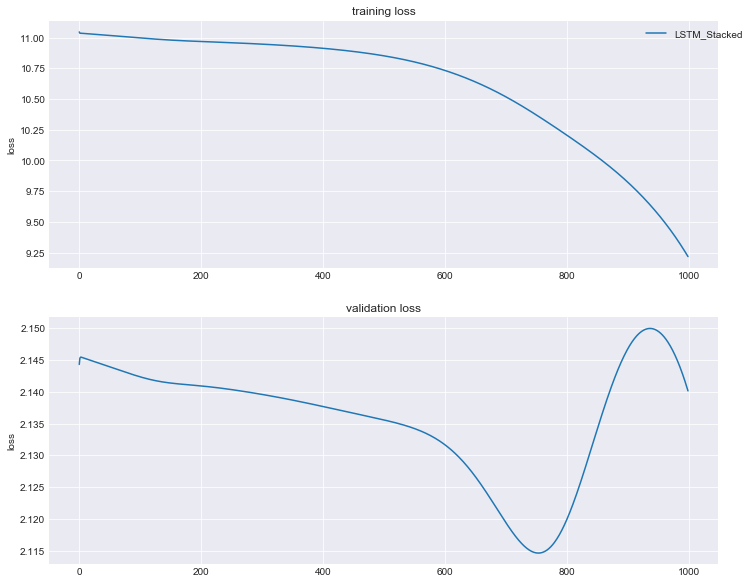

In [38]:
x = [i for i in range(n_epochs)]


fig, ax = plt.subplots(2,1, figsize=(12,10))

for model_ in models:
    name = model_[0]
    training_loss = model_[1]
    valid_loss =model_[2] 

    
    label = name 
    
    ax[0].plot(x,  training_loss, label=label)
    ax[1].plot(x,  valid_loss, label=label)
    #ax[2].plot([i for i in range(n_epochs-1)],  valid_loss[1:] / valid_loss[:-1] * 100, label=label)


#ax[2].set_xlabel('epoch') 

ax[0].set_ylabel('loss') 
ax[1].set_ylabel('loss')

ax[0].set_title("training loss")
ax[1].set_title("validation loss")
#ax[2].set_title("validation loss change in %")

legend  = ax[0].legend(bbox_to_anchor=(1.05, 1))

ax[0].grid()
ax[1].grid()
#ax[2].grid()

# Serializing best model

In [39]:

# =============================================================================
# # Serializing model 
# =============================================================================

wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project'
save_dir = os.path.join(wdir, 'pytorch_models')
model_name = 'rnn.torch'

if(not os.path.isdir(save_dir)):
    os.mkdir(save_dir)
    
save(model.state_dict(), os.path.join(save_dir, model_name))

#model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
#model.load_state_dict(load( os.path.join(save_dir, model_name)))

# Using model

In [13]:
country = 'Germany'

df = database_training_sv_standard[country].append(database_validation_sv_standard[country])

n_forecast_validation, _ = database_validation_sv_standard[country].shape

X_eval = df.iloc[:,1:].values
y_eval = df.iloc[:,0].values
X_eval_T = from_numpy(X_eval).float()
N, _ = X_eval_T.shape
X_eval_T = X_eval_T.view([-1, N, dummy_dim])

hidden_1 = zeros(1, N, hidden_dim)
state_1 = zeros(1, N, hidden_dim)

hidden_2 = zeros(1, N, hidden_dim)
state_2 = zeros(1, N, hidden_dim)

model.eval()
with no_grad():
    y_hat = model(X_eval_T, hidden_1, state_1, hidden_2, state_2)
    
y_hat =  y_hat.view(-1).numpy()
y_forecast = y_hat[-n_forecast_validation:]
y_forecast

array([0.01369219, 0.00042881, 0.00120457, 0.06186881, 0.01417604,
       0.01045175], dtype=float32)

# Comparing with the ground truth.

First check right application of scaling. The unscaled data must equal the scaled data after appling the inverse_transform method from sklearn: 

In [14]:
scaler = database_scaler[country]

database_validation_sv[country]

,y,GHG,Current account balance,General government net lending/borrowing,PPP,"Inflation, average consumer prices",ExchangeR
2005,2.051359,0.661859,1.852348,-0.058174,0.654957,1.051777,0.547797
2006,2.518101,0.640522,1.845025,-1.246360,0.662903,1.167132,0.503668
2007,2.072474,0.661971,1.786614,-6.907755,0.658295,1.140200,0.513078
2008,2.013436,0.617975,1.818870,3.318150,0.662904,0.706676,0.583932
2009,0.234375,0.690894,1.812187,0.607133,0.665526,1.869612,0.582607
2010,1.860920,0.634447,1.827969,-0.435978,0.659129,1.428403,0.525331


In [15]:
pd.DataFrame(scaler.inverse_transform(database_validation_sv_standard[country]))

,0,1,2,3,4,5,6
0,2.051359,0.661859,1.852348,-0.058174,0.654957,1.051777,0.547797
1,2.518101,0.640522,1.845025,-1.246360,0.662903,1.167132,0.503668
2,2.072474,0.661971,1.786614,-6.907755,0.658295,1.140200,0.513078
3,2.013436,0.617975,1.818870,3.318150,0.662904,0.706676,0.583932
4,0.234375,0.690894,1.812187,0.607133,0.665526,1.869612,0.582607
5,1.860920,0.634447,1.827969,-0.435978,0.659129,1.428403,0.525331


Transforming the output back to original scale: 

In [16]:
df_output = database_validation_sv_standard[country]

Overwriting the forecast to the dataframe in order to call the inverse_transform method.

In [17]:
df_output.iloc[:,0] = y_forecast
df_output

,0,1,2,3,4,5,6
0,0.013692,0.977376,0.233201,-1.540170,-1.811933,0.173565,0.031546
1,0.000429,-0.824086,0.229011,-5.745871,-0.464783,0.244783,-0.691070
2,0.001205,0.986829,0.195587,-25.784944,-1.245999,0.228155,-0.536981
3,0.061869,-2.727739,0.214045,10.410665,-0.464502,-0.039492,0.623240
4,0.014176,3.428772,0.210220,0.814749,-0.020067,0.678478,0.601555
5,0.010452,-1.337028,0.219251,-2.877446,-1.104656,0.406086,-0.336342


In [18]:
df_output = pd.DataFrame(scaler.inverse_transform(df_output))
df_output

,0,1,2,3,4,5,6
0,1.691698,0.661859,1.852348,-0.058174,0.654957,1.051777,0.547797
1,1.667858,0.640522,1.845025,-1.246360,0.662903,1.167132,0.503668
2,1.669252,0.661971,1.786614,-6.907755,0.658295,1.140200,0.513078
3,1.778293,0.617975,1.818870,3.318150,0.662904,0.706676,0.583932
4,1.692568,0.690894,1.812187,0.607133,0.665526,1.869612,0.582607
5,1.685873,0.634447,1.827969,-0.435978,0.659129,1.428403,0.525331


In [19]:
y_forecast = df_output.iloc[:,0].values
y_forecast

array([1.69169797, 1.66785757, 1.66925199, 1.7782935 , 1.69256768,
       1.6858734 ])

In [20]:
database_validation_sv[country].iloc[:,0].values

array([2.05135894, 2.51810131, 2.07247393, 2.01343609, 0.23437483,
       1.86092044])